#Internship Project
#Language Translation(German to English)

#Problem Statement:
The objective of the project is to implement language
translation model aka machine translation for converting
German to English (and vice versa)
For this, the data is a text file (.txt) of English-German sentence
pairs. The actual data contains over 150,000 sentence-pairs.
However, it is suggested to use only the first 50,000 sentence
pairs to reduce the training time of the model.

You can download the Data set from

http://www.manythings.org/anki/

#Text Pre-Processing
Quite an important step in any project, especially so in NLP.
The data we work with is more often than not unstructured so
there are certain things we need to take care of before jumping
to the model building part.

(a) Text Cleaning

(b) Text to Sequence Conversion

A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

In [1]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import models    
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.set_option('display.max_colwidth',200)

In [2]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

In [3]:
#function to input raw txt file
def ingest_txt(filename):
  #open the file
  file = open(filename, mode='rt', encoding = 'utf-8')
  #read all text
  text = file.read()
  file.close()
  return text

In [4]:
#spliting a txt into sentences
def txtto_phrase(text):
  sents = text.strip().split('\n')
  sents= [i.split('\t')for i in sents]
  return sents

In [5]:
data = ingest_txt("C:\deu.txt")
deu_eng = txtto_phrase(data)
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000,:]

In [7]:
# Initializing empty lists
engl1=[]
deut1=[]
# populate the list with sentence lengths
for i in deu_eng[:,0]:
  engl1.append(len(i.split()))
  
for i in deu_eng[:,1]:
    deut1.append(len(i.split()))

In [8]:
lengthdf = pd.DataFrame({'eng':engl1, 'deu':deut1})

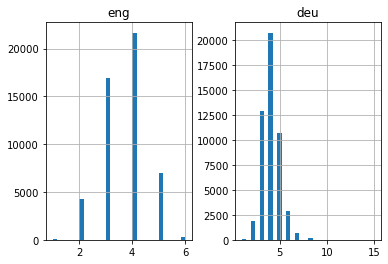

In [9]:
lengthdf.hist(bins=30)
plt.show()

In [10]:
# method to construct a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [11]:
#constructing english tokenizer
engltokenizer = tokenization(deu_eng[:,0])
englvocab_size = len(engltokenizer.word_index)+1

engllength = 8
print('Size of English Vocabulary: %d'% englvocab_size)

Size of English Vocabulary: 6150


In [12]:
len(engltokenizer.word_index)

6149

In [13]:
#prepare Deutch tokenizer
deuttokenizer = tokenization(deu_eng[:,1])
deutvocab_size = len(deuttokenizer.word_index)+1

deutlength = 8
print('Deutch Vocabulary Size: %d'% deutvocab_size)

Deutch Vocabulary Size: 10119


In [14]:
#encode and pad sequence
def encode_sequences(tokenizer, length, lines):
  #integer encode sequence
  seq = tokenizer.texts_to_sequences(lines)
  #pad sequence with 0 values
  seq = pad_sequences(seq, maxlen = length, padding='post')
  return seq

In [17]:
from sklearn.model_selection import train_test_split
train, test  = train_test_split(deu_eng, test_size=0.2, random_state = 43)

In [18]:
#preparing training data
train_X = encode_sequences(deuttokenizer, deutlength, train[:, 1])
train_Y = encode_sequences(engltokenizer, engllength, train[:,0])

In [19]:
#preparing validation data
test_X = encode_sequences(deuttokenizer, deutlength, test[:, 1])
test_Y = encode_sequences(engltokenizer, engllength, test[:,0])

In [20]:
# building a NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [21]:
model = build_model(deutvocab_size, englvocab_size, deutlength, engllength, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=None)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [22]:
filename = 'deu2eng_model'
Checkpoint = ModelCheckpoint(filename, monitor= 'val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(train_X, train_Y.reshape(train_Y.shape[0], train_Y.shape[1], 1),
                   epochs=20, batch_size=512,
                   validation_split = 0.5,
                   callbacks=[Checkpoint], verbose=1)

Epoch 1/20
40/40 [==============================] - 115s 3s/step - loss: 3.6675 - val_loss: 2.9616

Epoch 00001: val_loss improved from inf to 2.96157, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 2/20
40/40 [==============================] - 106s 3s/step - loss: 2.7845 - val_loss: 2.7515

Epoch 00002: val_loss improved from 2.96157 to 2.75154, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 3/20
40/40 [==============================] - 107s 3s/step - loss: 2.6881 - val_loss: 2.7548

Epoch 00003: val_loss did not improve from 2.75154
Epoch 4/20
40/40 [==============================] - 108s 3s/step - loss: 2.5947 - val_loss: 2.5891

Epoch 00004: val_loss improved from 2.75154 to 2.58911, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 5/20
40/40 [==============================] - 109s 3s/step - loss: 2.4641 - val_loss: 2.6175

Epoch 00005: val_loss did not improve from 2.58911
Epoch 6/20
40/40 [==============================] - 109s 3s/step - loss: 2.3669 - val_loss: 2.4732

Epoch 00006: val_loss improved from 2.58911 to 2.47323, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 7/20
40/40 [==============================] - 109s 3s/step - loss: 2.2784 - val_loss: 2.4135

Epoch 00007: val_loss improved from 2.47323 to 2.41347, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 8/20
40/40 [==============================] - 107s 3s/step - loss: 2.1893 - val_loss: 2.3555

Epoch 00008: val_loss improved from 2.41347 to 2.35550, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 9/20
40/40 [==============================] - 107s 3s/step - loss: 2.1015 - val_loss: 2.2843

Epoch 00009: val_loss improved from 2.35550 to 2.28430, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 10/20
40/40 [==============================] - 108s 3s/step - loss: 2.0231 - val_loss: 2.2259

Epoch 00010: val_loss improved from 2.28430 to 2.22588, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 11/20
40/40 [==============================] - 108s 3s/step - loss: 1.9491 - val_loss: 2.2055

Epoch 00011: val_loss improved from 2.22588 to 2.20547, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 12/20
40/40 [==============================] - 108s 3s/step - loss: 1.8800 - val_loss: 2.1359

Epoch 00012: val_loss improved from 2.20547 to 2.13586, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 13/20
40/40 [==============================] - 108s 3s/step - loss: 1.8117 - val_loss: 2.0927

Epoch 00013: val_loss improved from 2.13586 to 2.09270, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 14/20
40/40 [==============================] - 108s 3s/step - loss: 1.7456 - val_loss: 2.0717

Epoch 00014: val_loss improved from 2.09270 to 2.07168, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 15/20
40/40 [==============================] - 108s 3s/step - loss: 1.6823 - val_loss: 2.0305

Epoch 00015: val_loss improved from 2.07168 to 2.03055, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 16/20
40/40 [==============================] - 108s 3s/step - loss: 1.6227 - val_loss: 2.0129

Epoch 00016: val_loss improved from 2.03055 to 2.01289, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 17/20
40/40 [==============================] - 108s 3s/step - loss: 1.5599 - val_loss: 1.9879

Epoch 00017: val_loss improved from 2.01289 to 1.98794, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 18/20
40/40 [==============================] - 108s 3s/step - loss: 1.5002 - val_loss: 1.9403

Epoch 00018: val_loss improved from 1.98794 to 1.94031, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 19/20
40/40 [==============================] - 108s 3s/step - loss: 1.4398 - val_loss: 1.9096

Epoch 00019: val_loss improved from 1.94031 to 1.90955, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


Epoch 20/20
40/40 [==============================] - 107s 3s/step - loss: 1.3821 - val_loss: 1.8673

Epoch 00020: val_loss improved from 1.90955 to 1.86728, saving model to deu2eng_model


INFO:tensorflow:Assets written to: deu2eng_model\assets


INFO:tensorflow:Assets written to: deu2eng_model\assets


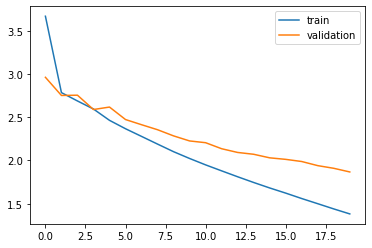

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [24]:
#model = load_model('deu2eng_model')  #Uncomment to load if not in memory
preds = model.predict(test_X)

In [25]:
#Constructing an inverse lookup for english vocab
eng_inv_dict  = {v:k for k,v in engltokenizer.word_index.items()}

In [26]:
#Creating final dataframe with actual and predicted
translated_df = pd.DataFrame(data={'test':test[:,0]})

In [28]:
translated_list = []
for i,_ in enumerate(preds):
    translated_list.append(' '.join([eng_inv_dict.get(np.argmax(j), '') for j in preds[i]]))

In [29]:
translated_df['predicted'] = pd.Series(translated_list)

In [30]:
translated_df

,test,predicted
0,Tom shot Mary.,tom saw mary mary
1,I can help you now.,i can help you
2,Turn it on.,come it in
3,Tom is merciless.,tom is quite
4,That's for suckers.,it's what i i
...,...,...
9995,Go away!,come away
9996,Something is coming.,this one to
9997,You'll be happy.,you look busy
9998,Do you like these?,do you like this
